In [1]:
# Set up libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
from configparser import ConfigParser
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 


Bad key "text.kerning_factor" on line 4 in
C:\Users\HOME\Anaconda3\envs\SEGP\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Configure the connection
config = ConfigParser()
config.read("config.ini")
options = config["DataBase"]

engine = create_engine("mysql://" + options["user"] + ":" + options["passwd"] + "@" + options["host"] + "/" + options["database"])
engine.connect()

In [3]:
## Rough work for weekly predictions
# Set up the SQL command and turn into dataframe
stat_2 = "SELECT * FROM dublinbikes.dynamic_data WHERE number = 2"
sql_df = pd.read_sql(stat_2,engine)
print(sql_df.shape)
sql_df

(11352, 6)


,number,last_update,bike_stands,available_bike_stands,available_bikes,status
0,2,1581417540,20,20,0,OPEN
1,2,1581418200,20,20,0,OPEN
2,2,1581418800,20,20,0,OPEN
3,2,1581419400,20,20,0,OPEN
4,2,1581420000,20,20,0,OPEN
...,...,...,...,...,...,...
11347,2,1586965167000,20,14,6,OPEN
11348,2,1586965734000,20,15,5,OPEN
11349,2,1586966343000,20,16,4,OPEN
11350,2,1586966925000,20,18,2,OPEN


In [4]:
# check for duplicates
print("Number of duplicate rows: ", sql_df.duplicated().sum())
print("Number of duplicate columns: ", sql_df.T.duplicated().sum())

Number of duplicate rows:  0
Number of duplicate columns:  0


In [5]:
# looking at 'last_update'
count, count2 = 0,0
for line in sql_df['last_update']:
    if len(str(line)) > 10:
        count += 1
    else:
        count2 += 1
        
print("Last update in len 10 format: ", count2)
print("Last update in len 13 format: ", count)

Last update in len 10 format:  3981
Last update in len 13 format:  7371


In [6]:
# converting 'last_update' enties from 13 digits to the required 10
for i in range(sql_df.shape[0]):
    convert = str(sql_df['last_update'][i])
    if len(convert) > 10:
        sql_df.at[i,'last_update'] = int(convert[:10])


In [7]:
print("Number of duplicate rows: ", sql_df.duplicated().sum())
print("Number of duplicate columns: ", sql_df.T.duplicated().sum())

Number of duplicate rows:  1
Number of duplicate columns:  0


In [8]:
sql_df[sql_df.duplicated(keep=False)]

,number,last_update,bike_stands,available_bike_stands,available_bikes,status
3980,2,1583234161,20,20,0,OPEN
3981,2,1583234161,20,20,0,OPEN


In [9]:
sql_df = sql_df.drop_duplicates()
sql_df = sql_df.reset_index(drop=True)
print(sql_df.shape)
sql_df.head(5)


(11351, 6)


,number,last_update,bike_stands,available_bike_stands,available_bikes,status
0,2,1581417540,20,20,0,OPEN
1,2,1581418200,20,20,0,OPEN
2,2,1581418800,20,20,0,OPEN
3,2,1581419400,20,20,0,OPEN
4,2,1581420000,20,20,0,OPEN


In [10]:
# moving target feature to end
sql_df = sql_df[['number', 'last_update', 'bike_stands', 'available_bike_stands', 'status', 'available_bikes']]
sql_df.head(5)

,number,last_update,bike_stands,available_bike_stands,status,available_bikes
0,2,1581417540,20,20,OPEN,0
1,2,1581418200,20,20,OPEN,0
2,2,1581418800,20,20,OPEN,0
3,2,1581419400,20,20,OPEN,0
4,2,1581420000,20,20,OPEN,0


In [11]:
# convert update to datetime
sql_df['last_update'] = sql_df['last_update'].apply(lambda x: datetime.fromtimestamp(x))
sql_df.head(5)

,number,last_update,bike_stands,available_bike_stands,status,available_bikes
0,2,2020-02-11 10:39:00,20,20,OPEN,0
1,2,2020-02-11 10:50:00,20,20,OPEN,0
2,2,2020-02-11 11:00:00,20,20,OPEN,0
3,2,2020-02-11 11:10:00,20,20,OPEN,0
4,2,2020-02-11 11:20:00,20,20,OPEN,0


In [12]:
# adding day of the week column
sql_df.insert(2, 'day_of_week', 0)
sql_df['day_of_week'] = sql_df['last_update'].apply(lambda x: x.dayofweek )
sql_df

,number,last_update,day_of_week,bike_stands,available_bike_stands,status,available_bikes
0,2,2020-02-11 10:39:00,1,20,20,OPEN,0
1,2,2020-02-11 10:50:00,1,20,20,OPEN,0
2,2,2020-02-11 11:00:00,1,20,20,OPEN,0
3,2,2020-02-11 11:10:00,1,20,20,OPEN,0
4,2,2020-02-11 11:20:00,1,20,20,OPEN,0
...,...,...,...,...,...,...,...
11346,2,2020-04-15 16:39:27,2,20,14,OPEN,6
11347,2,2020-04-15 16:48:54,2,20,15,OPEN,5
11348,2,2020-04-15 16:59:03,2,20,16,OPEN,4
11349,2,2020-04-15 17:08:45,2,20,18,OPEN,2


In [13]:
# remove lines of repeated data
r_day, r_stand, r_bike = 0,0,0
clean_sql_df = pd.DataFrame()
for i in range(sql_df.shape[0]):
    c_day = sql_df['day_of_week'][i]
    c_stand = sql_df['available_bike_stands'][i]
    c_bike = sql_df['available_bikes'][i]
    if r_day == c_day and r_stand == c_stand and r_bike == c_bike:
        continue
    else:
        r_day, r_stand, r_bike = c_day, c_stand, c_bike
        clean_sql_df = clean_sql_df.append([sql_df.iloc[i]])


clean_sql_df = clean_sql_df.reset_index(drop=True)
clean_sql_df

,number,last_update,day_of_week,bike_stands,available_bike_stands,status,available_bikes
0,2,2020-02-11 10:39:00,1,20,20,OPEN,0
1,2,2020-02-11 11:26:00,1,20,19,OPEN,1
2,2,2020-02-11 11:39:00,1,20,20,OPEN,0
3,2,2020-02-11 15:38:00,1,20,19,OPEN,1
4,2,2020-02-11 15:43:00,1,20,18,OPEN,2
...,...,...,...,...,...,...,...
2990,2,2020-04-15 16:39:27,2,20,14,OPEN,6
2991,2,2020-04-15 16:48:54,2,20,15,OPEN,5
2992,2,2020-04-15 16:59:03,2,20,16,OPEN,4
2993,2,2020-04-15 17:08:45,2,20,18,OPEN,2


In [21]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [22]:
# Preparing Data
cont_features = ['day_of_week']
X = clean_sql_df[cont_features]
y = clean_sql_df.available_bikes

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print(X_train)
# train the model
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)

In [23]:
train_predictions = linreg.predict(X_train)
print("Actual values of training:\n", y_train)
print("Predictions on training:", train_predictions)
printMetrics(y_train, train_predictions)

Actual values of training:
 1499    4
1901    6
1269    6
2690    2
1283    1
       ..
763     1
835     5
1653    0
2607    3
2732    9
Name: available_bikes, Length: 2096, dtype: int64
Predictions on training: [4.74790129 4.74790129 6.70416458 ... 7.35625234 5.39998905 7.35625234]

MAE:  4.146052387620647
RMSE:  4.9825027002133995
R2:  0.05366406897997755


In [24]:
test_predictions = linreg.predict(X_test)
print("Actual values of training:\n", y_test)
print("Predictions on training:", test_predictions)
printMetrics(y_test, test_predictions)

Actual values of training:
 1300     6
263      2
1768     3
2115    13
812      0
        ..
1041    10
1888    10
2437    12
1224    10
1079     1
Name: available_bikes, Length: 899, dtype: int64
Predictions on training: [6.70416458 4.74790129 6.05207682 5.39998905 7.35625234 6.05207682
 5.39998905 7.35625234 6.05207682 7.35625234 6.70416458 6.70416458
 6.05207682 6.05207682 6.05207682 6.70416458 5.39998905 6.70416458
 4.74790129 5.39998905 5.39998905 5.39998905 5.39998905 7.35625234
 4.09581353 4.74790129 6.70416458 7.35625234 5.39998905 7.35625234
 6.70416458 6.05207682 8.0083401  4.74790129 8.0083401  7.35625234
 7.35625234 4.74790129 5.39998905 8.0083401  4.09581353 8.0083401
 8.0083401  8.0083401  5.39998905 5.39998905 6.05207682 5.39998905
 5.39998905 4.74790129 8.0083401  4.09581353 7.35625234 7.35625234
 6.70416458 6.70416458 6.05207682 4.09581353 4.74790129 4.74790129
 6.05207682 5.39998905 8.0083401  5.39998905 4.74790129 6.70416458
 5.39998905 6.05207682 4.09581353 8.00834

In [25]:
# predict whole table
predicted_bikes = linreg.predict(X)
pb_df = clean_sql_df.assign(predicted_bikes=predicted_bikes)

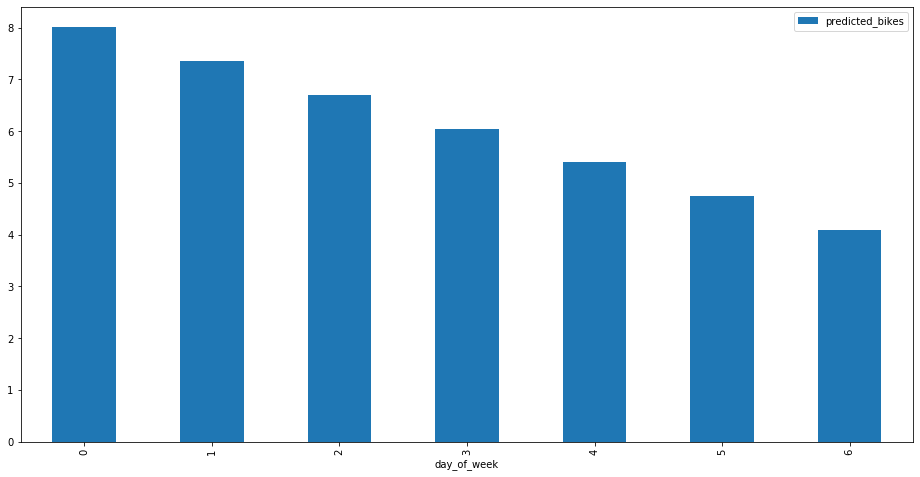

In [26]:
plot_data = pb_df[['day_of_week','predicted_bikes']]
plot_data = plot_data.groupby('day_of_week').mean()
# plot_out = plot_data.plot(x=plot_data[0], y='predicted_bikes',kind='bar', figsize=(16,8))
# plot_data = plot_data.groupby(['day_of_week','predicted_bikes']).count().unstack('predicted_bikes').fillna(0)
plot_out = plot_data.plot(kind='bar', stacked=True, figsize=(16,8))


In [34]:
clean_sql_df
usage_data = pd.DataFrame(columns=['day_of_week', 'usage'])
r_day,r_count = 0,0

for i in range(clean_sql_df.shape[0]):
    c_day = clean_sql_df['day_of_week'][i]
    date = clean_sql_df['last_update'][i]
    if date.month == 3 and date.day > 15:
        usage_data.loc[i] = [r_day] + [r_count]
        break
    if r_day != c_day and r_count == 0:
        r_day = c_day
        r_count += 1
    elif r_day != c_day and r_count > 0:
        usage_data.loc[i] = [r_day] + [r_count]
        r_day = c_day
        r_count = 1
    elif r_day == c_day:
        r_count += 1
    else:
        print("Something Odd in the Data {} {} {}".format(r_day,r_count,c_day))
usage_data = usage_data.reset_index(drop=True)
usage_data

,day_of_week,usage
0,1,35
1,2,50
2,3,65
3,4,65
4,5,55
5,6,35
6,0,34
7,1,29
8,2,99
9,3,76


In [35]:
# Preparing Data
cont_features = ['day_of_week']
X = usage_data[cont_features]
y = usage_data.usage

# split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print(X_train)
# train the model
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X, y)

In [36]:
# train_predictions = linreg.predict(X_train)
# print("Actual values of training:\n", y_train)
# print("Predictions on training:", train_predictions)
# printMetrics(y_train, train_predictions)

[59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578, 60.527559055118104, 59.366254218222714, 58.20494938132733, 57.04364454443194, 55.88233970753655, 54.72103487064116, 53.55973003374578]
   day_of_week usage  predicted_usage
0            1    35        59.366254
1            2    50        58.204949
2            3    65        57.043645
3            4    65        55.882340
4            5    55        54.721035
5            6    35        53.559730
6            0    34        60.527559
7            1    29        59.366254
8 

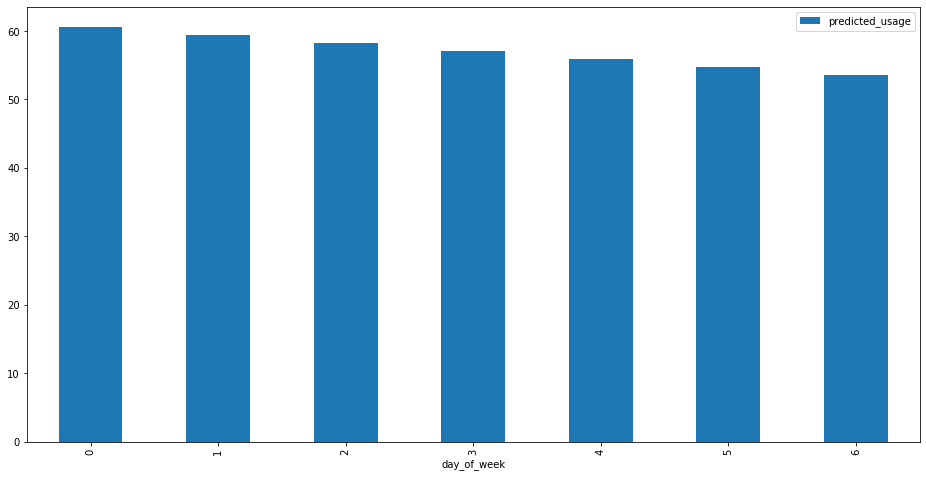

In [37]:
# predict whole table
predicted_usage = linreg.predict(X)
print(list(predicted_usage))
pu_df = usage_data.assign(predicted_usage=predicted_usage)
print(pu_df)
plot_data = pu_df[['day_of_week','predicted_usage']]
plot_data = plot_data.groupby('day_of_week').mean()
# plot_out = plot_data.plot(x=plot_data[0], y='predicted_bikes',kind='bar', figsize=(16,8))
# plot_data = plot_data.groupby(['day_of_week','predicted_bikes']).count().unstack('predicted_bikes').fillna(0)
plot_out = plot_data.plot(kind='bar', stacked=True, figsize=(16,8))


In [38]:
temp_data = pu_df[['day_of_week','usage']]
# temp_data.to_csv ('export_dataframe.csv', index = False, header=True)

In [39]:
df_0 = pd.DataFrame()
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_3 = pd.DataFrame()
df_4 = pd.DataFrame()
df_5 = pd.DataFrame()
df_6 = pd.DataFrame()

for i in range(usage_data.shape[0]):
    if usage_data['day_of_week'][i] == 0:
        df_0 = df_0.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 1:
        df_1 = df_1.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 2:
        df_2 = df_2.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 3:
        df_3 = df_3.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 4:
        df_4 = df_4.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 5:
        df_5 = df_5.append([usage_data.iloc[i]])
    if usage_data['day_of_week'][i] == 6:
        df_6 = df_6.append([usage_data.iloc[i]])
        


[41.75]
Empty DataFrame
Columns: [day_of_week, predict]
Index: []
73.6


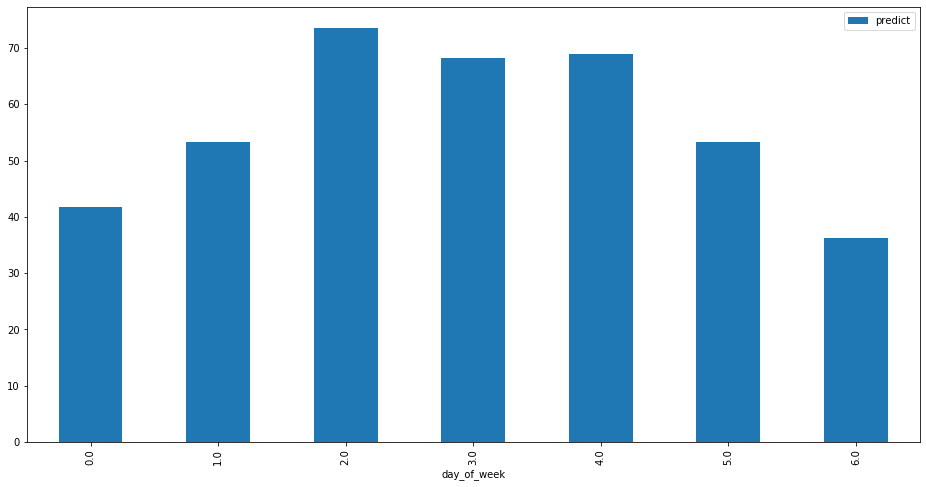

In [40]:
# playing around dont mind this
X0 = df_0[cont_features]
y0 = df_0.usage
linreg0 = LinearRegression().fit(X0, y0)

X1 = df_1[cont_features]
y1 = df_1.usage
linreg1 = LinearRegression().fit(X1, y1)

X2 = df_2[cont_features]
y2 = df_2.usage
linreg2 = LinearRegression().fit(X2, y2)

X3 = df_3[cont_features]
y3 = df_3.usage
linreg3 = LinearRegression().fit(X3, y3)

X4 = df_4[cont_features]
y4 = df_4.usage
linreg4 = LinearRegression().fit(X4, y4)

X5 = df_5[cont_features]
y5 = df_5.usage
linreg5 = LinearRegression().fit(X5, y5)

X6 = df_6[cont_features]
y6 = df_6.usage
linreg6 = LinearRegression().fit(X6, y6)

xdata = [0, 1, 2, 3, 4, 5, 6]
print(linreg0.predict(X0.head(1)))
ydata = [linreg0.predict(X0.head(1)),linreg1.predict(X1.head(1)),linreg2.predict(X2.head(1)),linreg3.predict(X3.head(1)),linreg4.predict(X4.head(1)),linreg5.predict(X5.head(1)),linreg6.predict(X6.head(1))]
plotdata2 = pd.DataFrame(columns = ['day_of_week', 'predict'])
print(plotdata2)
for i in xdata:
    plotdata2.loc[i] = [xdata[i]]+[ydata[i][0]]
print(plotdata2.predict[2])
plotdata2 = plotdata2.groupby('day_of_week').mean()
plot_out = plotdata2.plot(kind='bar', stacked=True, figsize=(16,8))

# comment in to update predicton tables(developers only only)
# sql = "INSERT INTO dublinbikes.station_week_prediction (number, mon, tue, wed, thur, fri, sat, sun) VALUES ({}, {}, {}, {}, {}, {}, {}, {});".format(2,plotdata2.predict[0],plotdata2.predict[1],plotdata2.predict[2],plotdata2.predict[3],plotdata2.predict[4],plotdata2.predict[5],plotdata2.predict[6])
# sql2 = "UPDATE dublinbikes.station_week_prediction SET mon = 1, tue = 1, wed = 1, thur = 1, fri = 1, sat = 1, sun = 1 WHERE (number = 2);"
# print(sql)
# try:
#     engine.execute(sql)
# except:
#     engine.execute(sql2)



In [27]:
# def weekModelBuilding():
station = "SELECT number FROM dublinbikes.static_data"
stat_df = pd.read_sql(station,engine)
print(stat_df.shape)
stat_df.head(5)

(109, 1)


,number
0,2
1,3
2,4
3,5
4,6


In [52]:
station = 2
bikes_data = """SELECT bd.number, bd.last_update, bd.available_bikes, wa.weather_station
                FROM dublinbikes.bike_weather_assoc wa, dublinbikes.dynamic_data bd
                WHERE bd.number=wa.bike_station_id and bd.number = {} and bd.last_update < 1584316800000;""".format(station)
bikes_df = pd.read_sql(bikes_data, engine)

weather_data = "SELECT name, weather_id, main_temp, main_humidity, wind_speed, dt FROM dublinbikes.weather_dynamic WHERE name = '{}';".format(bikes_df.weather_station[0])

weather_df = pd.read_sql(weather_data, engine)

In [53]:
bikes_df.head(5)

,number,last_update,available_bikes,weather_station
0,2,1581417540,0,Drumcondra
1,2,1581418200,0,Drumcondra
2,2,1581418800,0,Drumcondra
3,2,1581419400,0,Drumcondra
4,2,1581420000,0,Drumcondra


In [54]:
weather_df.head(5)

,name,weather_id,main_temp,main_humidity,wind_speed,dt
0,Drumcondra,803,276.66,80.0,4.1,1582749064
1,Drumcondra,802,279.98,62.0,8.7,1582814540
2,Drumcondra,803,276.57,69.0,3.1,1582836811
3,Drumcondra,803,276.62,69.0,3.1,1582837802
4,Drumcondra,803,277.13,69.0,2.6,1582839002


In [55]:
weather_df.shape

(8727, 6)

In [56]:
## cleaning bikes data
# converting 'last_update' enties from 13 digits to the required 10
for i in range(bikes_df.shape[0]):
    convert = str(bikes_df['last_update'][i])
    if len(convert) > 10:
        bikes_df.at[i,'last_update'] = int(convert[:10])
# removing duplicates
bikes_df = bikes_df.drop_duplicates()
bikes_df = bikes_df.reset_index(drop=True)
# convert update to datetime
bikes_df['last_update'] = bikes_df['last_update'].apply(lambda x: datetime.fromtimestamp(x))
# adding day of the week column
bikes_df.insert(2, 'day_of_week', 0)
bikes_df['day_of_week'] = bikes_df['last_update'].apply(lambda x: x.dayofweek )
bikes_df.insert(2, 'hour_of_day', 0)
bikes_df['hour_of_day'] = bikes_df['last_update'].apply(lambda x: x.hour )
bikes_df

,number,last_update,hour_of_day,day_of_week,available_bikes,weather_station
0,2,2020-02-11 10:39:00,10,1,0,Drumcondra
1,2,2020-02-11 10:50:00,10,1,0,Drumcondra
2,2,2020-02-11 11:00:00,11,1,0,Drumcondra
3,2,2020-02-11 11:10:00,11,1,0,Drumcondra
4,2,2020-02-11 11:20:00,11,1,0,Drumcondra
...,...,...,...,...,...,...
6457,2,2020-03-15 23:29:40,23,6,6,Drumcondra
6458,2,2020-03-15 23:32:27,23,6,7,Drumcondra
6459,2,2020-03-15 23:44:48,23,6,7,Drumcondra
6460,2,2020-03-15 23:45:19,23,6,7,Drumcondra


In [57]:
## cleaning weather data
# removing duplicates
weather_df = weather_df.drop_duplicates()
weather_df = weather_df.reset_index(drop=True)
# convert update to datetime
weather_df['dt'] = weather_df['dt'].apply(lambda x: datetime.fromtimestamp(x))

In [58]:
weather_df

,name,weather_id,main_temp,main_humidity,wind_speed,dt
0,Drumcondra,803,276.66,80.0,4.1,2020-02-26 20:31:04
1,Drumcondra,802,279.98,62.0,8.7,2020-02-27 14:42:20
2,Drumcondra,803,276.57,69.0,3.1,2020-02-27 20:53:31
3,Drumcondra,803,276.62,69.0,3.1,2020-02-27 21:10:02
4,Drumcondra,803,277.13,69.0,2.6,2020-02-27 21:30:02
...,...,...,...,...,...,...
8722,Drumcondra,803,278.22,93.0,2.1,2020-04-15 23:25:07
8723,Drumcondra,803,278.22,93.0,2.1,2020-04-15 23:30:07
8724,Drumcondra,801,278.27,100.0,2.6,2020-04-15 23:40:07
8725,Drumcondra,801,278.28,100.0,2.6,2020-04-15 23:45:07


In [59]:
# creating the new combined table with default values
combined_df = bikes_df
# space for weather data
combined_df = combined_df.assign(weather_id=0, main_temp=0, main_humidity=0,wind_speed=0, weather_time=datetime.fromtimestamp(1))
# space for one hot encoding
combined_df = combined_df.assign(d1=0,d2=0,d3=0,h1=0,h2=0,h3=0,h4=0,h5=0)
combined_df

,number,last_update,hour_of_day,day_of_week,available_bikes,weather_station,weather_id,main_temp,main_humidity,wind_speed,weather_time,d1,d2,d3,h1,h2,h3,h4,h5
0,2,2020-02-11 10:39:00,10,1,0,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
1,2,2020-02-11 10:50:00,10,1,0,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
2,2,2020-02-11 11:00:00,11,1,0,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
3,2,2020-02-11 11:10:00,11,1,0,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
4,2,2020-02-11 11:20:00,11,1,0,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,2,2020-03-15 23:29:40,23,6,6,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
6458,2,2020-03-15 23:32:27,23,6,7,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
6459,2,2020-03-15 23:44:48,23,6,7,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
6460,2,2020-03-15 23:45:19,23,6,7,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0


In [49]:
## joing both tables based on closest weather time(+- 6 mins)
# start by removing rows that are dated before the earliest date time of the weather data
combined_df = combined_df[combined_df.last_update>= (weather_df.dt[0] - timedelta(minutes = 10) )]
combined_df = combined_df.reset_index(drop=True)
combined_df

,number,last_update,hour_of_day,day_of_week,available_bikes,weather_station,weather_id,main_temp,main_humidity,wind_speed,weather_time,d1,d2,d3,h1,h2,h3,h4,h5
0,2,2020-02-26 20:23:52,20,2,18,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
1,2,2020-02-26 20:34:01,20,2,17,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
2,2,2020-02-26 20:44:09,20,2,17,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
3,2,2020-02-26 20:48:40,20,2,17,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
4,2,2020-02-26 20:49:42,20,2,17,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8516,2,2020-04-15 23:19:46,23,2,8,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
8517,2,2020-04-15 23:29:54,23,2,8,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
8518,2,2020-04-15 23:40:03,23,2,8,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0
8519,2,2020-04-15 23:50:12,23,2,8,Drumcondra,0,0,0,0,1970-01-01 00:00:01,0,0,0,0,0,0,0,0


In [60]:
# combine the closest weather date row with the corrisponding bike row 
w_count = 0
for i in range(combined_df.shape[0]):
    # current date to check against
    c_date = combined_df.last_update[i]
    # used in tracking the last timedelta checked
    time_deltaL = abs(c_date - weather_df.dt[w_count+1])
    # used in tracking the best time delta in the loop
    best = 0
    # check the next rows for as long as the time
    for c in range(1, weather_df.shape[0]-w_count):
        # the current best time delta bike_date-weather_date (closest weather date available)
        time_deltaC = abs(c_date - weather_df.dt[w_count+best])
        # the next time delta controlled by loop
        time_deltaN = abs(c_date - weather_df.dt[w_count+c])
        # if current best td < next td (next row)
        if time_deltaC < time_deltaN:
            # do nothing
            pass
        else:
            # make best this row
            best = c
        # if the current next td is bigger than the last loops td
        if time_deltaN > time_deltaL:
            # exit the loop and prevent going through every itereation
            # e.g if the best was updated on the last loop but this loop has
            # a bigger td then exit as the ones that follow will keep getting bigger
            break
        else:
            # update last td
            time_deltaL = time_deltaN
    # update the row count on the weather
    w_count += best
    # populate current row with wether data
    combined_df.at[i,'weather_id'] = weather_df.weather_id[w_count]
    combined_df.at[i,'main_temp'] = weather_df.main_temp[w_count]
    combined_df.at[i,'main_humidity'] = weather_df.main_humidity[w_count]
    combined_df.at[i,'wind_speed'] = weather_df.wind_speed[w_count]
    combined_df.at[i,'weather_time'] = weather_df.dt[w_count]
    # populate the current row with OHE data from day and hour
    day_bin = '{0:03b}'.format(combined_df.day_of_week[i])
    hour_bin = '{0:05b}'.format(combined_df.hour_of_day[i])
    combined_df.at[i,'d1'] = int(day_bin[-1])
    combined_df.at[i,'d2'] = int(day_bin[-2])
    combined_df.at[i,'d3'] = int(day_bin[-3])
    combined_df.at[i,'h1'] = int(hour_bin[-1])
    combined_df.at[i,'h2'] = int(hour_bin[-2])
    combined_df.at[i,'h3'] = int(hour_bin[-3])
    combined_df.at[i,'h4'] = int(hour_bin[-4])
    combined_df.at[i,'h5'] = int(hour_bin[-5])
combined_df

,number,last_update,hour_of_day,day_of_week,available_bikes,weather_station,weather_id,main_temp,main_humidity,wind_speed,weather_time,d1,d2,d3,h1,h2,h3,h4,h5
0,2,2020-02-11 10:39:00,10,1,0,Drumcondra,803,276,80,4,2020-02-26 20:31:04,1,0,0,0,1,0,1,0
1,2,2020-02-11 10:50:00,10,1,0,Drumcondra,803,276,80,4,2020-02-26 20:31:04,1,0,0,0,1,0,1,0
2,2,2020-02-11 11:00:00,11,1,0,Drumcondra,803,276,80,4,2020-02-26 20:31:04,1,0,0,1,1,0,1,0
3,2,2020-02-11 11:10:00,11,1,0,Drumcondra,803,276,80,4,2020-02-26 20:31:04,1,0,0,1,1,0,1,0
4,2,2020-02-11 11:20:00,11,1,0,Drumcondra,803,276,80,4,2020-02-26 20:31:04,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,2,2020-03-15 23:29:40,23,6,6,Drumcondra,801,276,94,2,2020-03-15 23:30:06,0,1,1,1,1,1,0,1
6458,2,2020-03-15 23:32:27,23,6,7,Drumcondra,801,276,94,2,2020-03-15 23:30:06,0,1,1,1,1,1,0,1
6459,2,2020-03-15 23:44:48,23,6,7,Drumcondra,801,275,94,3,2020-03-15 23:42:05,0,1,1,1,1,1,0,1
6460,2,2020-03-15 23:45:19,23,6,7,Drumcondra,801,275,94,3,2020-03-15 23:42:05,0,1,1,1,1,1,0,1


In [62]:
# Preparing Data
cont_features = ['weather_id', 'main_temp', 'main_humidity','wind_speed','d1','d2','d3','h1','h2','h3','h4','h5']
X = combined_df[cont_features]
y = combined_df.available_bikes

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

hour_day_linreg = LinearRegression().fit(X_train, y_train)

In [68]:
# predict whole table
print(X_test)
predicted_bikes = hour_day_linreg.predict(X_test)
print(predicted_bikes)
pb_df = X_test
pb_df = pb_df.assign(available_bikes=y_test,predicted_bikes=predicted_bikes)
# show all information for day1 hour9
pb_df[(pb_df['d1'] == 0) & (pb_df['d2'] == 1) & (pb_df['d3'] == 0) & (pb_df['h1'] == 1) & (pb_df['h2'] == 0) & (pb_df['h3'] == 0) & (pb_df['h4'] == 0) & (pb_df['h5'] == 1)]

      weather_id  main_temp  main_humidity  wind_speed  d1  d2  d3  h1  h2  \
1122         803        276             80           4   1   0   0   1   1   
3101         803        276             69           3   1   1   0   1   0   
1996         803        276             80           4   1   0   1   1   0   
3585         801        276             71           6   0   1   1   0   0   
5461         520        281             81           6   1   0   0   1   0   
...          ...        ...            ...         ...  ..  ..  ..  ..  ..   
203          803        276             80           4   0   1   0   1   0   
578          803        276             80           4   0   0   1   0   1   
1245         803        276             80           4   0   1   0   1   1   
5552         520        281             81           6   1   0   0   1   1   
2182         803        276             80           4   0   1   1   1   0   

      h3  h4  h5  
1122   0   0   1  
3101   1   0   1  
1996  

,weather_id,main_temp,main_humidity,wind_speed,d1,d2,d3,h1,h2,h3,h4,h5,available_bikes,predicted_bikes
5723,520,279,75,9,0,1,0,1,0,0,0,1,5,4.250791
2831,803,276,80,4,0,1,0,1,0,0,0,1,15,5.909813
154,803,276,80,4,0,1,0,1,0,0,0,1,3,5.909813
1357,803,276,80,4,0,1,0,1,0,0,0,1,1,5.909813
1362,803,276,80,4,0,1,0,1,0,0,0,1,2,5.909813
4266,801,279,75,3,0,1,0,1,0,0,0,1,1,5.916559
1363,803,276,80,4,0,1,0,1,0,0,0,1,1,5.909813
1364,803,276,80,4,0,1,0,1,0,0,0,1,1,5.909813
2828,803,276,80,4,0,1,0,1,0,0,0,1,14,5.909813
2836,803,276,80,4,0,1,0,1,0,0,0,1,18,5.909813


In [41]:
with open('model.pkl', 'wb') as handle:
    pickle.dump(hour_day_linreg, handle, pickle.HIGHEST_PROTOCOL)

In [42]:
with open('model.pkl', 'rb') as handle:
    model_test = pickle.load(handle) 
    
test = combined_df.iloc[4187:4188]
prediction = hour_day_linreg.predict(test[cont_features])
test2 = test.assign(predicted=prediction)

In [43]:
test2

,number,last_update,hour_of_day,day_of_week,available_bikes,weather_station,weather_id,main_temp,main_humidity,wind_speed,weather_time,d1,d2,d3,h1,h2,h3,h4,h5,predicted
4187,2,2020-03-20 02:48:26,2,4,17,Drumcondra,801,272,92,4,2020-03-20 02:51:05,0,0,1,0,1,0,0,0,7.931252
